In [40]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pandoc is already the newest version (1.19.2.4~dfsg-1build4).
texlive is already the newest version (2017.20180305-1).
texlive-latex-extra is already the newest version (2017.20180305-2).
texlive-xetex is already the newest version (2017.20180305-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [41]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [42]:
!pip install -q albumentations==0.4.6

## Imports

In [43]:

import os
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
from torchvision.transforms import transforms as T
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from PIL import Image



## Customized Dataset

In [ ]:
y=[]
for i in range(1,81):
  v=f'img_{i}.png'
  y.append(v)
class Data(Dataset):#Dataset stores the samples and their corresponding labels
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = []
        
        for i in y:
          for j in os.listdir(image_dir):
            if i==j:
              self.images.append(j)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
            

        return image, mask

## Unet Model

In [ ]:

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)


In [ ]:
Device = "cuda" if torch.cuda.is_available() else "cpu"
model=UNET(3,1).to(Device)


## Visualize image and mask

torch.Size([1, 3, 300, 300])
img_dim_after_running_model torch.Size([1, 1, 300, 300])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


img_shape:  (300, 300)
label_shape:  torch.Size([1, 300, 300])


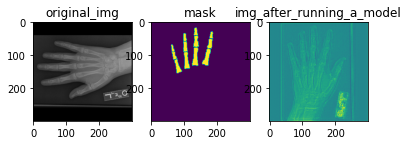

In [ ]:

IMG_DIR='/content/gdrive/MyDrive/Bone_Age_Detection /50images'
LABEL_DIR='/content/gdrive/MyDrive/Bone_Age_Detection /50label'
VAL_IMG_DIR='/content/gdrive/MyDrive/Bone_Age_Detection /Val_data'
VAL_MASK_DIR='/content/gdrive/MyDrive/Bone_Age_Detection /Val_masks'
Device = "cuda" if torch.cuda.is_available() else "cpu"

train_transforms = A.Compose([A.Resize(height=300, width=300), A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0), ToTensorV2()])
val_transforms = A.Compose([A.Resize(height=300, width=300), A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0), ToTensorV2()])

train_data=Data(IMG_DIR, LABEL_DIR, train_transforms)
train_load=DataLoader(train_data, batch_size=1, shuffle=True)#DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

val_data=Data(VAL_IMG_DIR, VAL_MASK_DIR, val_transforms)
val_load=DataLoader(train_data, batch_size=1, shuffle=False)

batch= next(iter(train_load)) #Each iteration below returns a batch of train_features and train_labels (containing batch_size features and labels respectively). Because we specified shuffle=True, after we iterate over all batches the data is shuffled
image, label = batch
image=image.to(Device)
mm=torch.sigmoid(model(image))

with torch.no_grad(): #disable gradient calculation. when you are sure that you will not call Tensor.backward(). It will reduce memory consumption for computations
  m=torch.sigmoid(model(image)).squeeze(0).squeeze(0).cpu().numpy()#squeeze removes axes that have length of 1
  

image=image.cpu()
image=image.squeeze(0)
image=image.numpy().transpose(2,1,0)#diplayed img is rotated bcz of transpose but img passed in model will be upright
label=label.squeeze(0).numpy()

plt.subplot(1,3,1)
plt.title('original_img')
plt.imshow(image)#(300, 300, 3)

plt.subplot(1,3,2)
plt.title('mask')
plt.imshow(label)#(300, 300)

plt.subplot(1,3,3)
plt.title('model_output')
plt.imshow(m)



## Hyperparameters

In [ ]:
IMG_DIR='/content/gdrive/MyDrive/Bone_Age_Detection /50images'
LABEL_DIR='/content/gdrive/MyDrive/Bone_Age_Detection /50label'
VAL_IMG_DIR='/content/gdrive/MyDrive/Bone_Age_Detection /test_img'
VAL_MASK_DIR='/content/gdrive/MyDrive/Bone_Age_Detection /Test_mask'

Device = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE=8
NUM_EPOCHS=8
LEARNING_RATE=0.00001

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
'''
model=UNET(3,1).to(Device)
model.load_state_dict(torch.load('/content/gdrive/MyDrive/Bone_Age_Detection /preds/model_weights.pth'))
optimizer.load_state_dict(torch.load('/content/gdrive/MyDrive/Bone_Age_Detection /preds/optimizer.pth'))
model.eval()
'''

train_data=Data(IMG_DIR, LABEL_DIR, train_transforms)
train_loader=DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

val_data=Data(VAL_IMG_DIR, VAL_MASK_DIR, val_transforms)
val_loader=DataLoader(train_data, batch_size=1, shuffle=False)



## Check Accuracy

---



In [ ]:


def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()
#model.eval() is a kind of switch for some specific layers/parts of the model that behave differently during training and inference (evaluating) time. It will turn off  Dropouts Layers, BatchNorm Layers etc. 
#common practice for evaluating/validation is using torch.no_grad() in pair with model.eval() to turn off gradients computation.
#we need to turn back to training mode after eval step.

    with torch.no_grad():#we don't use gradients during evaluation, so turning off the autograd will speed up execution and will reduce memory usage
        for x, y in loader:
            x = x.to(Device)
            y = y.to(Device).unsqueeze(1)
            preds = torch.sigmoid(model(x))#
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)#calculate number of elements in a tensor
            dice_score += (2 * (preds * y).sum()) / (#calculate area of overlap between mask and prediction
                (preds + y).sum() + 1e-8
            )

    print(f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}")
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

#turn off evaluation mode by running model.train(). You should use it when running your model as an inference engine - i.e. when testing, validating, and predicting 

## Train

In [ ]:
def main():
    
    scaler = torch.cuda.amp.GradScaler()
       
    for epoch in range(NUM_EPOCHS):
      loop = tqdm(train_loader)
      #tqdm is a Python library that allows you to output a smart progress bar by wrapping around any iterable
      #tqdm progress bar gives us information that includes the task completion percentage, number of iterations complete, time elapsed, estimated time remaining,
      # and the iterations completed per second.
      
      for batch_idx, (data, targets) in enumerate(loop):
          l=0
          data = data.to(device=Device)
          targets = targets.float().unsqueeze(1).to(device=Device)

          # forward
          with torch.cuda.amp.autocast():
              predictions =model(data)
              loss = loss_fn(predictions, targets)#predictions and target should be of same size

          # backward
          optimizer.zero_grad()# zero out the gradients that are held in the grad attribute of weights
          scaler.scale(loss).backward()#calculate gradient which are used to update weight
          scaler.step(optimizer)#Update the weights
          scaler.update()
          l+=loss.item()
     
          # update tqdm loop
          loop.set_postfix(loss=loss.item())#set_postfix to add values directly to the bar. 
      check_accuracy(val_loader, model, device=Device)

main()

100%|██████████| 10/10 [00:17<00:00,  1.76s/it, loss=0.355]


Got 7122857/7200000 with acc 98.93
Dice score: 0.8312054872512817


100%|██████████| 10/10 [00:17<00:00,  1.77s/it, loss=0.352]


Got 7127560/7200000 with acc 98.99
Dice score: 0.8379535675048828


100%|██████████| 10/10 [00:17<00:00,  1.78s/it, loss=0.352]


Got 7129181/7200000 with acc 99.02
Dice score: 0.8402606248855591


100%|██████████| 10/10 [00:17<00:00,  1.78s/it, loss=0.356]


Got 7130061/7200000 with acc 99.03
Dice score: 0.8415457606315613


100%|██████████| 10/10 [00:17<00:00,  1.78s/it, loss=0.356]


Got 7130272/7200000 with acc 99.03
Dice score: 0.8418413996696472


100%|██████████| 10/10 [00:17<00:00,  1.78s/it, loss=0.356]


Got 7130003/7200000 with acc 99.03
Dice score: 0.8413832783699036


100%|██████████| 10/10 [00:17<00:00,  1.78s/it, loss=0.351]


Got 7129403/7200000 with acc 99.02
Dice score: 0.8404666185379028


100%|██████████| 10/10 [00:17<00:00,  1.78s/it, loss=0.359]


Got 7128591/7200000 with acc 99.01
Dice score: 0.8389860987663269


## Save predictions and mask

In [ ]:
val_transforms = A.Compose([ A.Resize(height=256, width=256),A.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0],max_pixel_value=255.0),ToTensorV2()])
val_trans=T.Compose([T.ToTensor(), T.Resize(300)])


def save_pred(img_path, mask_path,folder):

        image = Image.open(img_path).convert("RGB")#
        mask = Image.open(mask_path).convert("L")#

        image=val_trans(image)#torch.Size([3, 300, 300])
        mask=val_trans(mask)#torch.Size([3, 300, 300])
        mask[mask == 255.0] = 1.0

        image, mask = image.unsqueeze(0).to(Device), mask.unsqueeze(0).to(Device)
    
        model.eval()
        with torch.no_grad():
            preds =torch.sigmoid(model(image))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(preds, f"{folder}/pred_{i}.png")
        torchvision.utils.save_image(image, f"{folder}{i}.png")
              
        model.train()
for i in range(1,12):
  save_pred(f'/content/gdrive/MyDrive/Bone_Age_Detection /Val_data/img_{i}.png',f'/content/gdrive/MyDrive/Bone_Age_Detection /Val_masks/img_{i}.png','/content/gdrive/MyDrive/Bone_Age_Detection /preds/')


## Merge test image

In [ ]:
def merg_img(original_image, prediction):#this are PIL images RGB
  r1,g1,b1= original_image.split()
  r2,g2,b2= prediction.split()
  new_img=Image.merge('RGB', (r1,g1,b2))
  new_img.save(f'/content/gdrive/MyDrive/Bone_Age_Detection /preds/mergedmask{i}.png')
  
for i in range(1,12):
    original=Image.open(f'/content/gdrive/MyDrive/Bone_Age_Detection /Val_data/img_{i}.png').convert('RGB')
    pred=Image.open(f'/content/gdrive/MyDrive/Bone_Age_Detection /Val_masks/img_{i}.png').convert('RGB')

    merg_img(original, pred)


### Display original image, true mask, predicted mask, merged image

Text(0.5, 1.0, 'merged_ori_img_and_predicted_mask')

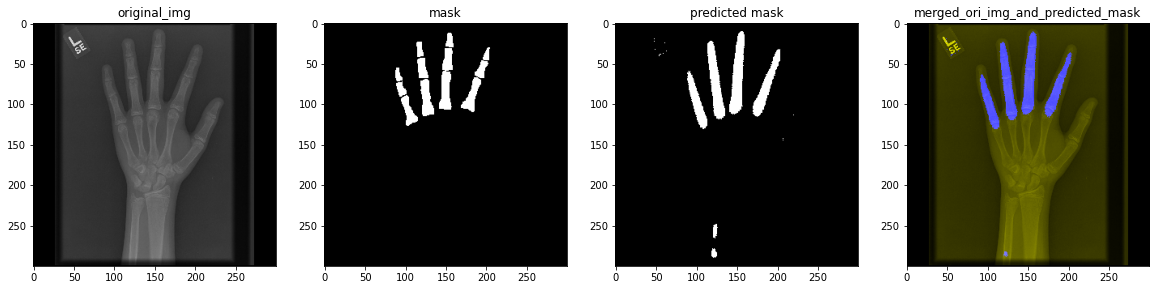

In [ ]:
path1='/content/gdrive/MyDrive/Bone_Age_Detection /Val_data/img_10.png'
path2='/content/gdrive/MyDrive/Bone_Age_Detection /Val_masks/img_10.png'
path3='/content/gdrive/MyDrive/Bone_Age_Detection /preds/pred_10.png'
path4='/content/gdrive/MyDrive/Bone_Age_Detection /preds/merged10.png'
img1=Image.open(path1)
img2=Image.open(path2)
img3=Image.open(path3)
img4=Image.open(path4)
plt.figure(figsize=(20,20))
plt.subplot(1,4,1)
plt.imshow(img1)
plt.title('original_img')
plt.subplot(1,4,2)
plt.imshow(img2,)
plt.title('mask')
plt.subplot(1,4,3)
plt.imshow(img3)
plt.title('predicted mask')
plt.subplot(1,4,4)
plt.imshow(img4)
plt.title('merged_ori_img_and_predicted_mask')

In [ ]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/Bone_Age_Detection /preds/model_weights.pth')
# state_dict is simply a Python dictionary object that maps each layer to its parameter tensor.

In [ ]:
torch.save(model, '/content/gdrive/MyDrive/Bone_Age_Detection /preds/model.pth')

In [ ]:
torch.save(optimizer.state_dict(), '/content/gdrive/MyDrive/Bone_Age_Detection /preds/optimizer.pth')